In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Deep Learning Model with Keras LSTM, using both Adjusted Close and Volume Parameters
Reference: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

Develop Stacked Model per DLNDF
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
# Fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Merge
from keras.layers import Activation, Dropout
from keras.metrics import mean_squared_error
# Import fix for Tensorflow 1.0 control flow ops w/ Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates

# Import utility libraries
import datetime
import time

Using TensorFlow backend.


In [2]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '2009-01-01', '2011-06-18'#'2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

# Set Baseline Model Ticker
base_ticker = tick_0

In [3]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter+1)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close     Volume
0     1  2009-01-02  78.738477  227566300
1     2  2009-01-05  78.645305  240349700
2     3  2009-01-06  79.170456  328260900
3     4  2009-01-07  76.798813  280899200
4     5  2009-01-08  77.112211  263834400
---
     Item        Date   Adj_Close     Volume
615   616  2011-06-13  113.330427  207599800
616   617  2011-06-14  114.768144  160570400
617   618  2011-06-15  112.726945  300958000
618   619  2011-06-16  112.975443  308032800
619   620  2011-06-17  113.312574  233284900


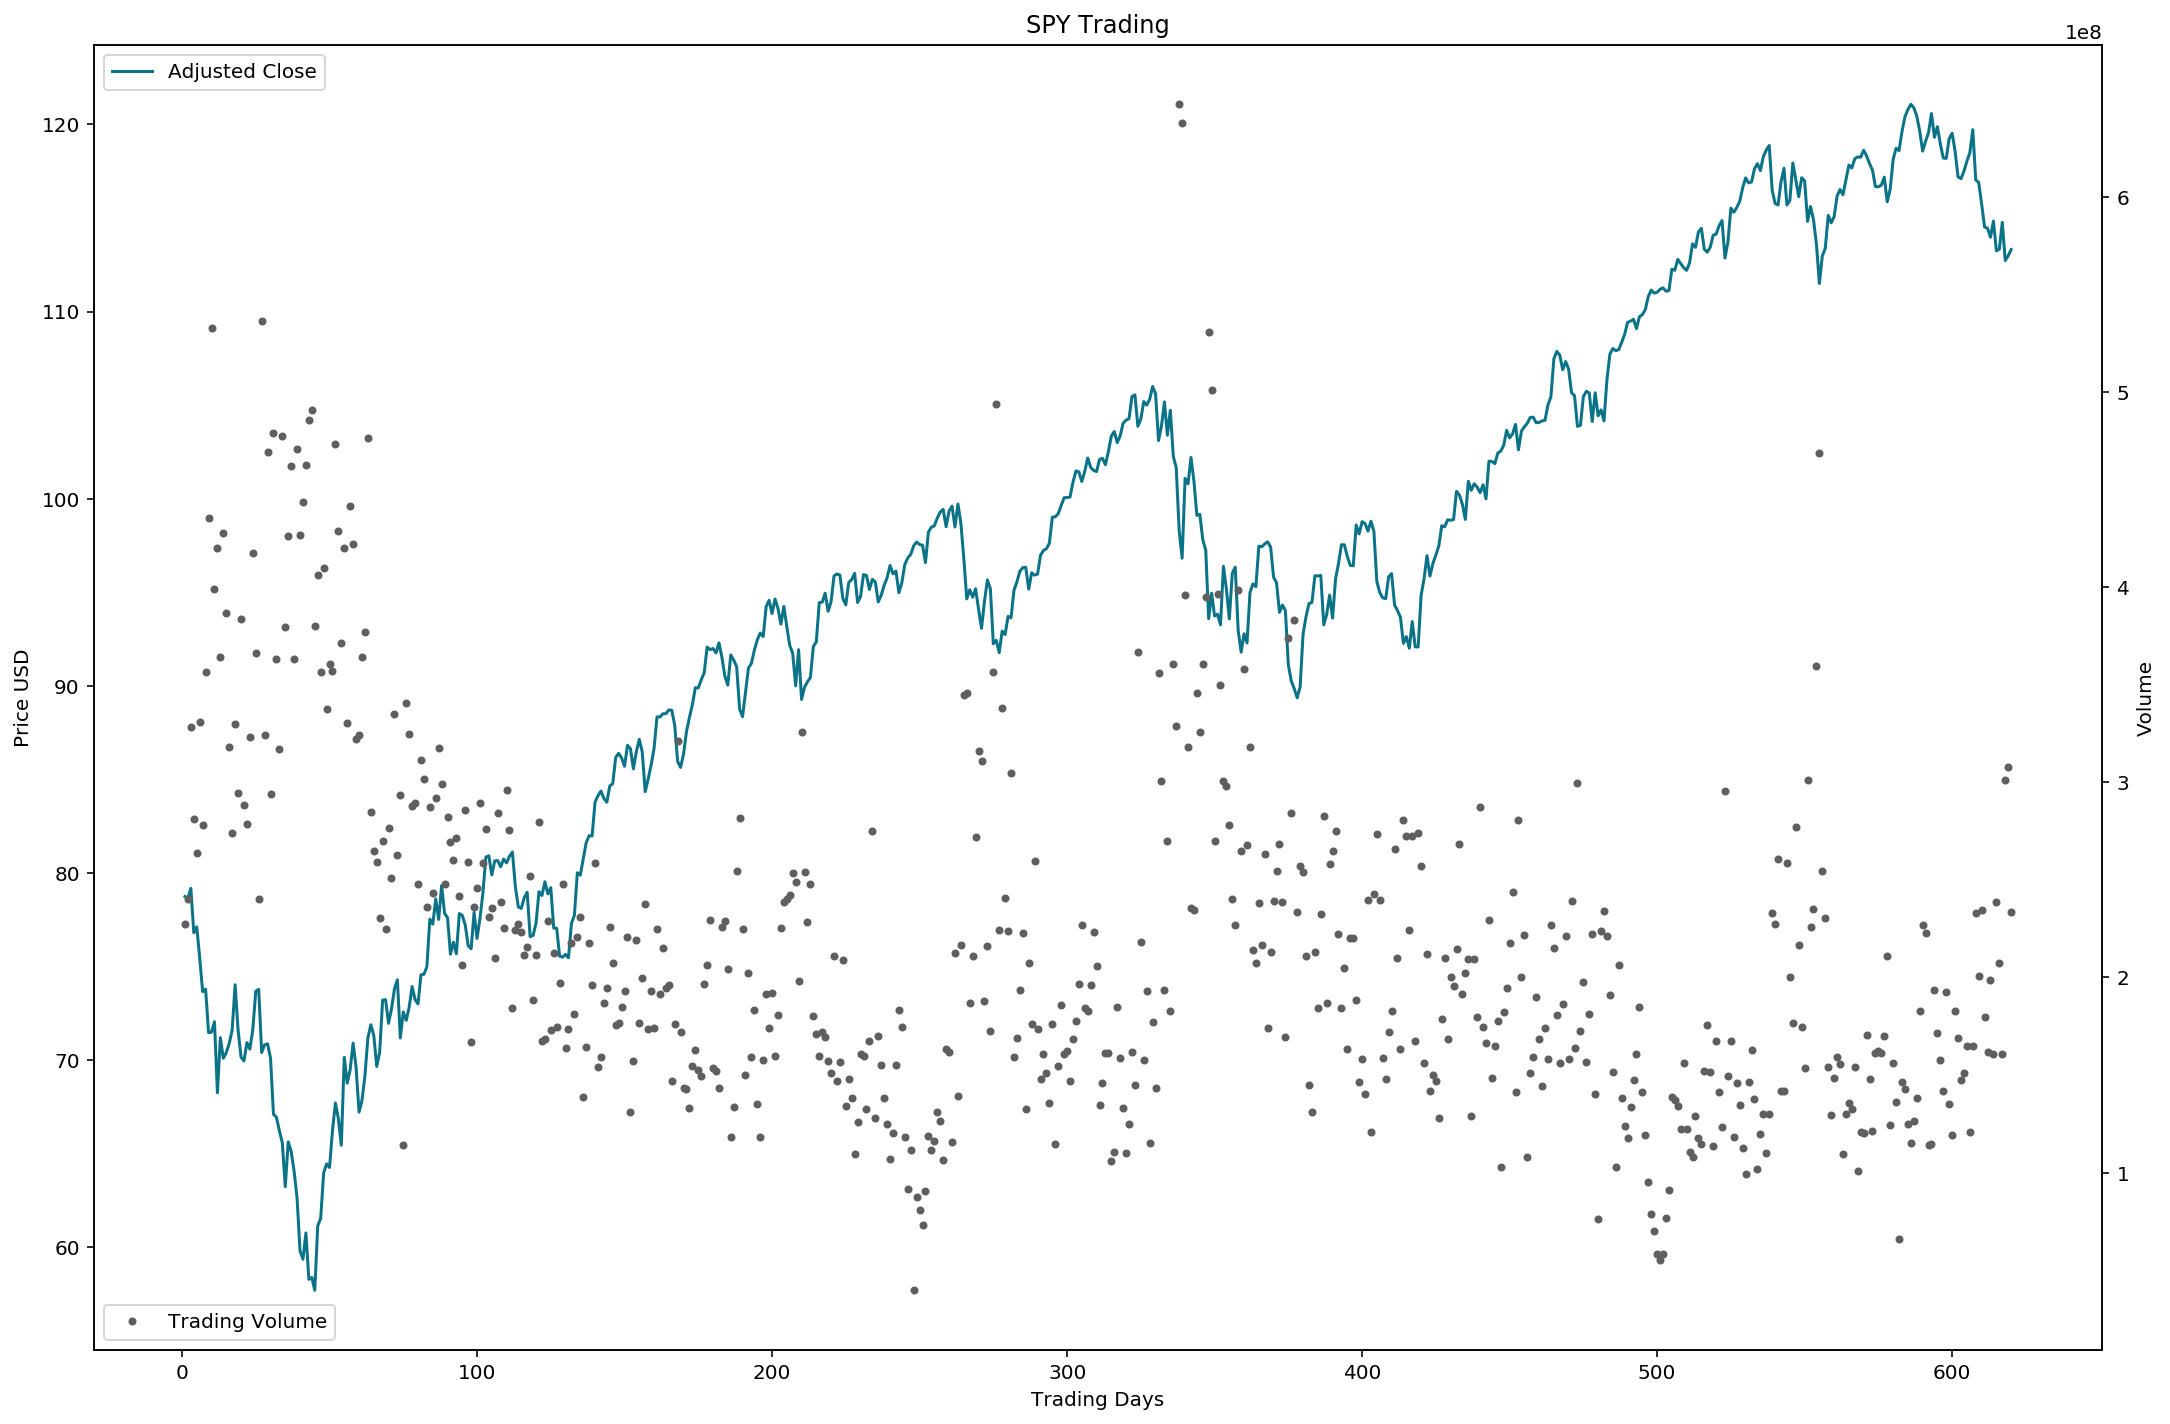

In [5]:
# Plot Basic Data
fig, ax1 = plt.subplots()
# Axis 1 - Adjusted Close
ax1.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388', label='Adjusted Close')
# Set X Axis label
ax1.set_xlabel('Trading Days')
# Set Y Axis label
ax1.set_ylabel('Price USD')

# Axis 2 - Volume
ax2 = ax1.twinx()
ax2.plot(stock_df['Item'], stock_df['Volume'], 'r.', color='#5f5f5f', label='Trading Volume')
# Set Y Axis label
ax2.set_ylabel('Volume')

# Add labels
plt.xlabel('Trading Days')

# Add title and legend
ax1.set_title(base_ticker + ' Trading')
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

plt.show()

In [9]:
#Create numpy arrays for features and targets
day_all = []
vol_all = []
close_all = []

#Convert dataframe columns to numpy arrays 
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    day_all.append(row['Item'])
    vol_all.append(row['Volume'])
    close_all.append(row['Adj_Close'])

#pprint(X_all)
#pprint(close_all)

# Store min/max of input data for rescaling later
day_bounds = [min(day_all), max(day_all)]
vol_bounds = [min(vol_all), max(vol_all)]
close_bounds = [min(close_all), max(close_all)]
print(close_bounds)

[57.690165, 121.078071]


In [10]:
# Convert an array of values into a dataset matrix
def create_dataset(data, seq_len=3, tt_split=0.90, normalise_window=True):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(tt_split * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return x_train, y_train, x_test, y_test

# Normalize the range of values in the lookback
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [12]:
# Reshape into t and t+1
look_back = 5 #50
tt_split = .90
#X_day_train_t, X_day_train_t1, X_day_test_t, X_day_test_t1 = create_dataset(X_day_all, look_back, tt_split, True)
#X_vol_train_t, X_vol_train_t1 = create_dataset(X_vol_train, look_back, True)
X_close_train, y_close_train, X_close_test, y_close_test = \
    create_dataset(close_all, look_back, tt_split, True)

pprint(X_close_train)
print('--')
pprint(y_close_train)

array([[[ 0.        ],
        [ 0.00902457],
        [ 0.00737656],
        [ 0.01467474],
        [ 0.01640119]],

       [[ 0.        ],
        [-0.01657059],
        [-0.01245079],
        [-0.01556353],
        [-0.04595811]],

       [[ 0.        ],
        [-0.00487234],
        [-0.00505283],
        [ 0.01741406],
        [ 0.01254173]],

       ..., 
       [[ 0.        ],
        [-0.00120658],
        [ 0.00439543],
        [ 0.00534347],
        [ 0.00844612]],

       [[ 0.        ],
        [-0.00141947],
        [-0.00177434],
        [-0.01135556],
        [ 0.00541165]],

       [[ 0.        ],
        [ 0.02013187],
        [ 0.02004394],
        [ 0.01881318],
        [ 0.02452747]]])
--
array([  6.43490559e-03,  -5.50215238e-02,   1.93088408e-02,
        -8.51920123e-05,   2.36383036e-02,  -5.42532251e-02,
         2.55673682e-02,   6.38769570e-02,   4.84285042e-02,
         4.11167194e-02,   1.70478679e-02,  -3.73947817e-02,
        -2.21400742e-03,   2.06360061e

In [13]:
# Create Keras Model
# http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

#TODO - Add Embeddings
# Create and fit the LSTM network
batch_size = 1
epochs = 1 # 200
# Create Stacked LSTM Network
model = Sequential()
model.add(LSTM(look_back,batch_input_shape=(batch_size, look_back, 1),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(look_back*2,return_sequences=False)) #, dropout_W=0.2))
model.add(Dropout(0.2))
model.add(Dense(output_dim=1))
model.add(Activation('linear'))

# Create LSTM Day network
#model1 = Sequential()
#model1.add(LSTM(8, batch_input_shape=(batch_size, look_back, 1)))
#model1.add(Dense(1))
# Create LSTM Volume network
#model2 = Sequential()
#model2.add(LSTM(8, batch_input_shape=(batch_size, look_back, 1)))
#model2.add(Dense(1))

# Create Merged Model
#merged_model = Merge([model1, model2], mode='sum', concat_axis=1)

# Create final composite model
#final_model = Sequential()
#final_model.add(merged_model)
# Potential add layers
#final_model.add(Dense(8))
#final_model.add(Dense(1))

start = time.time()
#final_model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='rmsprop')
print 'compilation time : ', time.time() - start


compilation time :  0.0998430252075


In [14]:
# Train the model

# Format inputs
#inputs = [X_day_train_t, X_vol_train_t]

model.fit(
    X_close_train, 
    y_close_train,  
    nb_epoch=epochs, 
    batch_size=batch_size, 
    verbose=2, 
    validation_split=0.05)

Train on 525 samples, validate on 28 samples
Epoch 1/1
4s - loss: 4.7743e-04 - val_loss: 3.6590e-04


In [15]:
# Generate predictions for training
trainPredict = model.predict(X_close_train, batch_size=batch_size)
testPredict = model.predict(X_close_test, batch_size=batch_size)
trainPredict_rescaled, r1 = scale_range(np.array(trainPredict), input_range=[0.0, 1.0], target_range=y_close_bounds)
testPredict_rescaled, r2 = scale_range(np.array(testPredict), input_range=[0.0, 1.0], target_range=y_close_bounds)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(X_day_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_rescaled)+look_back, :] = trainPredict_rescaled
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(X_day_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict_rescaled)+(look_back*2)+1:len(X_day_scaled)-1, :] = testPredict_rescaled

# Create actual values in aligned array
yPlot = np.empty_like(y_close_scaled)
yPlot[:, :] = np.nan
yPlot[-len(testPredict_rescaled):, :] = y_close_all[-len(testPredict_rescaled):]

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(yPlot,'#5F5F5F', label='Adjusted Close')
plt.plot(testPredictPlot, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

NameError: name 'scale_range' is not defined

In [ ]:
# The mean squared error
testScore = model.evaluate(y_close_test_t, y_close_test_t1, batch_size=batch_size, verbose=0)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore, math.sqrt(testScore)))

# Log of Results:
Epochs: 20

Dropout: 20%

### SPY
Lookback: 3 

LSTM = 8, Dense Layer1 = 1, Layer2 = Null, Layer3 = 1 

Test Score: 0.0047 MSE (0.0687 RMSE)


Lookback: 3 

LSTM = 3, LSTM = 100, Dense Layer1 = 1

Test Score: 0.0093 MSE (0.0965 RMSE)


Lookback: 3 

LSTM = 50, LSTM = 100, Dense Layer1 = 1

Test Score: 0.0171 MSE (0.1307 RMSE) rmsprop
Test Score: 0.0155 MSE (0.1245 RMSE) adam
Test Score: 0.0174 MSE (0.1321 RMSE) activation


Lookback: 30 

LSTM = 50, LSTM = 100, Dense Layer1 = 1

Test Score: 0.0177 MSE (0.1330 RMSE) 


Lookback: 3 

LSTM = 50, LSTM = 100, Dense Layer1 = 1



### GE
XX

### MSFT
XX

### AAPL
XX